In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree as ET
import xml.dom.minidom

Using TensorFlow backend.


In [2]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [3]:
config = myMaskRCNNConfig()

In [4]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "kangaroo")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        print(type(masks))
        print(masks)
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [6]:
dataset_dir = './kangaroo-master/'

(300, 450, 3)
<class 'numpy.ndarray'>
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
(300, 450, 4)


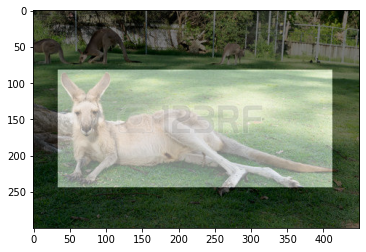

In [7]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo-master', is_train = True)
train_set.prepare()

# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap = 'gray', alpha = 0.5)
pyplot.show()

In [8]:
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "picture")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images1/'
        annotations_dir = dataset_dir + '/annots1/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path1 = annotations_dir + image_id + '.xml'
            ann_path2 = annotations_dir + 'pc-' + image_id + '.xml'
            # adding images and annotations to dataset
            if(os.path.exists(ann_path1)):
                # print('YES0')
                # print(ann_path1)
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path1)
            elif(os.path.exists(ann_path2)):
                # print('YES1')
                # print(ann_path2)
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path2)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        # tree = ElementTree.parse(filename)
        doc = xml.dom.minidom.parse(filename)
        # get the root of the document
        # root = tree.getroot()
        # extract each bounding box
        boxes = list()
        x = []
        y = []
        
                
        tree = ET.parse(filename)
        root = tree.getroot()
        print(root[1].attrib)
        
#         Page = doc.getElementsByTagName('Page')
        for item in doc.getElementsByTagName("ImageRegion"):
                for element in 
                for dims in doc.getElementsByTagName("Coords"):
                    pnt = doc.getElementsByTagName('Point')
                    for element in pnt:
                        x.append(int(element.getAttribute('x')))
                        y.append(int(element.getAttribute('y')))
                #print(x, y)
                boxes = [min(x), min(y), max(x), max(y)]
                #print(boxes)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        print(boxes, w, h)
        # create one array for all masks, each on a different channel
        masks = zeros((h, w, len(boxes)), dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

SyntaxError: invalid syntax (<ipython-input-8-3e77f5e17e0a>, line 54)

kangaroo-master/images/00075.jpg
(300, 450, 3)
<class 'numpy.ndarray'>
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
(300, 450, 4)


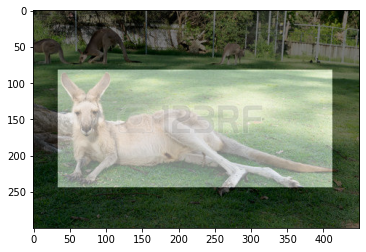

In [9]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo-master', is_train = True)
train_set.prepare()

# load an image
image_id = 0
imageName = os.path.join(dataset_dir,"00000085.tif")
image = train_set.load_image(image_id)
pyplot.imshow(image, cmap = 'gray')
imageLink = train_set.source_image_link(image_id)
print(imageLink)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap = 'gray', alpha = 0.5)
pyplot.show()

In [10]:
class LayoutDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "picture")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images1/'
        annotations_dir = dataset_dir + '/annots1/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path1 = annotations_dir + image_id + '.xml'
            ann_path2 = annotations_dir + 'pc-' + image_id + '.xml'
            # adding images and annotations to dataset
            if(os.path.exists(ann_path1)):
                # print('YES0')
                # print(ann_path1)
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path1)
            elif(os.path.exists(ann_path2)):
                # print('YES1')
                # print(ann_path2)
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path2)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        # tree = ElementTree.parse(filename)
        doc = xml.dom.minidom.parse(filename)
        # get the root of the document
        # root = tree.getroot()
        # extract each bounding box
        boxes = list()
        x = []
        y = []
        regs = []
   
        tree = ET.parse(filename)
        root = tree.getroot()
        tagPrefix = root.tag[:-5]
        page = root[1]
        count = 0
        pageFormat = page.attrib
        width = pageFormat['imageWidth']
        height = pageFormat['imageHeight']
        for elem in page.iter():
            #print(elem)
            if(elem.tag == (tagPrefix+'ImageRegion')):
                coords = elem[0]
                #print('COords: ', coords)
                for elem in coords.iter():
                    if(elem.tag == tagPrefix+'Point'):
                        #print(elem)
                        dims = elem.attrib
                        xi = int(dims['x'])
                        yi = int(dims['y'])
                        x.append(xi)
                        y.append(yi)
                        regs.append((xi, yi))
                        count += 1
        print(regs)
        print(count)
        # regs currently contains all points in a image region which are present
        # we have to divide it into pieces, split by 4 elements
        
        boxes = [min(x), min(y), max(x), max(y)]
        
        return boxes, width, height
        
        items = page[0] # it's an image, page[0] and others maybe 
        # anything else, textregion, other imageregion etc.
        print(items.tag == tagPrefix+'TextRegion')
        print(items)
        for item in items:
            print(item)
            dims = item[0]
            print(dims.attrib)
            
        allsitems = [elem.tag for elem in items.iter()]
        #print(allsitems)
        
        
        
    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        print(boxes, w, h)
        w = int(w)
        h = int(h)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype = np.uint8)
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = boxes[1], boxes[3]
            col_s, col_e = boxes[0], boxes[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('picture'))
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

kangaroo-master/images1/00000655.tif
(3054, 2394, 3)
[(718, 132), (718, 1654), (2252, 1654), (2252, 132)]
4
[718, 132, 2252, 1654] 2394 3054
Mask shape (3054, 2394, 4)


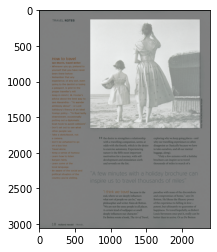

In [11]:
# train set
train_set = LayoutDataset()
train_set.load_dataset('kangaroo-master', is_train = True)
train_set.prepare()

# load an image
image_id = 0
# imageName = os.path.join(dataset_dir,"00000085.tif")
image = train_set.load_image(image_id)
pyplot.imshow(image, cmap = 'gray')
imageLink = train_set.source_image_link(image_id)
print(imageLink)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print('Mask shape', mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap = 'gray', alpha = 0.5)
pyplot.show()

[(718, 132), (718, 1654), (2252, 1654), (2252, 132)]
4
[718, 132, 2252, 1654] 2394 3054
[(460, 984), (460, 1012), (470, 1012), (470, 1050), (480, 1050), (480, 1112), (498, 1112), (498, 1090), (528, 1090), (528, 1076), (552, 1076), (552, 1050), (564, 1050), (564, 1032), (606, 1032), (606, 1082), (598, 1082), (598, 1108), (584, 1108), (584, 1156), (568, 1156), (568, 1198), (558, 1198), (558, 1216), (542, 1216), (542, 1220), (658, 1220), (658, 1206), (642, 1206), (642, 1160), (658, 1160), (658, 1112), (680, 1112), (680, 1086), (768, 1086), (768, 1050), (794, 1050), (794, 1036), (820, 1036), (820, 1022), (844, 1022), (844, 1004), (874, 1004), (874, 978), (898, 978), (898, 968), (934, 968), (934, 1012), (956, 1012), (956, 1000), (990, 1000), (990, 984), (1010, 984), (1010, 968), (1058, 968), (1058, 1008), (1044, 1008), (1044, 1044), (1026, 1044), (1026, 1078), (1008, 1078), (1008, 1098), (990, 1098), (990, 1118), (1128, 1118), (1128, 1096), (1112, 1096), (1112, 1028), (1146, 1028), (1146, 1

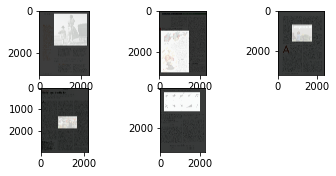

In [12]:
# plot first few images
for i in range(5):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [13]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': '00000655', 'source': 'dataset', 'path': 'kangaroo-master/images1/00000655.tif', 'annotation': 'kangaroo-master/annots1/pc-00000655.xml'}
{'id': '00000201', 'source': 'dataset', 'path': 'kangaroo-master/images1/00000201.tif', 'annotation': 'kangaroo-master/annots1/pc-00000201.xml'}
{'id': '00001001', 'source': 'dataset', 'path': 'kangaroo-master/images1/00001001.tif', 'annotation': 'kangaroo-master/annots1/00001001.xml'}
{'id': '00000394', 'source': 'dataset', 'path': 'kangaroo-master/images1/00000394.tif', 'annotation': 'kangaroo-master/annots1/00000394.xml'}
{'id': '00000800', 'source': 'dataset', 'path': 'kangaroo-master/images1/00000800.tif', 'annotation': 'kangaroo-master/annots1/00000800.xml'}
{'id': '00001256', 'source': 'dataset', 'path': 'kangaroo-master/images1/00001256.tif', 'annotation': 'kangaroo-master/annots1/pc-00001256.xml'}
{'id': '00001253', 'source': 'dataset', 'path': 'kangaroo-master/images1/00001253.tif', 'annotation': 'kangaroo-master/annots1/pc-00001253.

[(790, 1328), (790, 1896), (1646, 1896), (1646, 1328)]
4
[790, 1328, 1646, 1896] 2208 2996


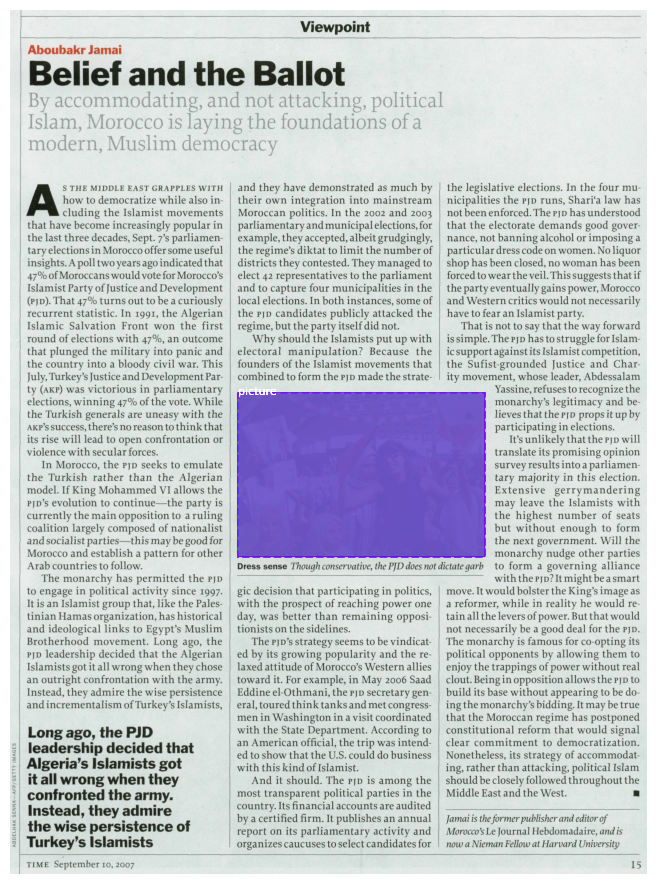

In [14]:
# define image id
image_id = 3
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [15]:
# define a configuration for the model
class LayoutConfig(Config):
	# Give the configuration a recognizable name
	NAME = "layout_cfg"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 131

# prepare config
config = LayoutConfig()

In [16]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [17]:
# load weights (COCO)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [20]:
# test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo-master', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 32


In [21]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./layout_cfg20200622T1345/mask_rcnn_layout_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.